In [ ]:
! pip install transformers
! pip install tqdm
! pip install wandb


# Required Libraries
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
import io
from transformers import BertModel
from transformers import BertTokenizer
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import wandb
import h5py
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score
import time
from sklearn.metrics import accuracy_score, recall_score
import random
from transformers import BertModel
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import torch
import torch
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.metrics import classification_report
from google.colab import drive
import pickle
from PIL import Image
import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from pathlib import Path
from transformers import AdamW, get_linear_schedule_with_warmup

from html import escape


drive.mount('/content/drive')
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=eabdd1fb3d798571d79175798eca2a2981286bd7ce7a33256a43096987527e91
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
Mounted at /content/drive
wand

## LOAD DATA

In [ ]:
### ALL DATA ###

folder_path = "/content/drive/MyDrive/thesis_files/"

def save_to_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

# Specify file names
X_file = folder_path + '/X_bert_word_12_all_1.pkl'
y_file = folder_path + '/y_bert_word_12_all_1.pkl'
attention_mask_file = folder_path + '/wordbert_attention_mask_12_all_1.pkl'
positions_file = folder_path + '/positions_bert_word_12_all_1.pkl'  # Added positions file

In [ ]:
### MEDIUM ONLY DATA ###

folder_path = "/content/drive/MyDrive/thesis_files/"

def save_to_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)


# New Data

# Specify file names
X_file = folder_path + '/X_bert_word_29_medium_third.pkl'
y_file = folder_path + '/y_bert_word_29_medium_third.pkl'
attention_mask_file = folder_path + '/wordbert_attention_mask_29_medium_third.pkl'
positions_file = folder_path + '/positions_bert_word_29_medium_third.pkl'  # Added positions file



In [ ]:
### LOAD DATA ###

# To load the data later
def load_from_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load the data
X = load_from_pickle(X_file)
y = load_from_pickle(y_file)
attention_masks = load_from_pickle(attention_mask_file)
positions = load_from_pickle(positions_file)  # Load positions

In [ ]:
## CLASSES

class BertForSequenceTagging(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_tags=4, num_BILSTM_layers=1):
        super(BertForSequenceTagging, self).__init__()
        self.bert_model = BertModel.from_pretrained(bert_model_name)
        self.positional_ffnn = nn.Linear(1, self.bert_model.config.hidden_size)  # New layer to process positional embeddings

        # Updated LSTM to have the specified number of BiLSTM layers
        self.word_lstm = nn.LSTM(self.bert_model.config.hidden_size, 100, num_layers=num_BILSTM_layers, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.word_output = nn.Linear(200, num_tags)

    def forward(self, document_input, mask_input, positions_input):  # Added positions_input
        bert_output = self.bert_model(document_input, attention_mask=mask_input)[0]
        positions_output = self.positional_ffnn(positions_input.unsqueeze(-1))  # Process positional embeddings
        bert_output = bert_output + positions_output  # Add positional embeddings to BERT output
        lstm_output, _ = self.word_lstm(bert_output)
        dropout_output = self.dropout(lstm_output)
        tag_logits = self.word_output(dropout_output)
        return tag_logits


#class BertForSequenceTagging(nn.Module):
#    def __init__(self, bert_model_name='bert-base-uncased', num_tags=4):
#        super(BertForSequenceTagging, self).__init__()
#        self.bert_model = BertModel.from_pretrained(bert_model_name)
#        self.positional_ffnn = nn.Linear(1, self.bert_model.config.hidden_size)  # New layer to process positional embeddings
#        self.word_lstm = nn.LSTM(self.bert_model.config.hidden_size, 100, bidirectional=True, batch_first=True)
#        self.dropout = nn.Dropout(0.1)
#        self.word_output = nn.Linear(200, num_tags)

#    def forward(self, document_input, mask_input, positions_input):  # Added positions_input
#        bert_output = self.bert_model(document_input, attention_mask=mask_input)[0]
#        positions_output = self.positional_ffnn(positions_input.unsqueeze(-1))  # Process positional embeddings
#        bert_output = bert_output + positions_output  # Add positional embeddings to BERT output
#        lstm_output, _ = self.word_lstm(bert_output)
#        dropout_output = self.dropout(lstm_output)
#        tag_logits = self.word_output(dropout_output)
#        return tag_logits

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, ignore_index=None):
        super().__init__()
        self.alpha = alpha
        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                self.alpha = torch.tensor(alpha).to(device)  # Move alpha to the device
            elif isinstance(alpha, torch.Tensor):
                self.alpha = alpha.to(device)  # Move alpha to the device
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, input, target):
        # Compute the negative log-likelihood
        if self.ignore_index is None:
            logpt = F.cross_entropy(input, target, reduction='none')
        else:
            logpt = F.cross_entropy(input, target, reduction='none', ignore_index=self.ignore_index)

        pt = torch.exp(-logpt)

        # Compute the focal loss
        if self.alpha is not None:
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        focal_loss = (1-pt)**self.gamma * logpt

        return focal_loss.mean()


In [ ]:
## FUNCTIONS

SEED=42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def split_data(X, y, attention_masks, positions, train_size, val_size, test_sizen, random_state):
    assert train_size + val_size + test_size == 1, "train_size, val_size, and test_size must sum up to 1"

    X_temp, X_test, y_temp, y_test, masks_temp, masks_test, positions_temp, positions_test = train_test_split(
        X, y, attention_masks, positions, test_size=test_size, random_state=random_state
    )

    # Adjust train_size to account for the previous split
    train_size_adjusted = train_size / (train_size + val_size)
    X_train, X_val, y_train, y_val, masks_train, masks_val, positions_train, positions_val = train_test_split(
        X_temp, y_temp, masks_temp, positions_temp, test_size=1 - train_size_adjusted, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, masks_train, masks_val, masks_test, positions_train, positions_val, positions_test


def setup_data(X, y, attention_masks, positions, train_size=0.8, val_size=0.1, test_size=0.1, batch_size=64, random_state=SEED, device=None):

    # Split the data into training, validation and testing sets
    X_train, X_val, X_test, y_train, y_val, y_test, attention_masks_train, attention_masks_val, attention_masks_test, positions_train, positions_val, positions_test = split_data(X, y, attention_masks, positions, train_size, val_size, test_size, random_state)
    print(f'X_train len: {len(X_train)}')
    print(f'X_val len: {len(X_val)}')
    print(f'X_test len: {len(X_train)}')
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train)
    X_val = torch.tensor(X_val)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_val = torch.tensor(y_val)
    y_test = torch.tensor(y_test)
    attention_masks_train = torch.tensor(attention_masks_train)
    attention_masks_val = torch.tensor(attention_masks_val)
    attention_masks_test = torch.tensor(attention_masks_test)
    positions_train = torch.tensor(positions_train, dtype=torch.float)  # Convert positions to float tensors
    positions_val = torch.tensor(positions_val, dtype=torch.float)  # Convert positions to float tensors
    positions_test = torch.tensor(positions_test, dtype=torch.float)  # Convert positions to float tensors

    # If a device is not provided, use CUDA if available
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the data to the specified device
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_val = y_val.to(device)
    y_test = y_test.to(device)
    attention_masks_train = attention_masks_train.to(device)
    attention_masks_val = attention_masks_val.to(device)
    attention_masks_test = attention_masks_test.to(device)
    positions_train = positions_train.to(device)  # Move positions to the GPU
    positions_val = positions_val.to(device)  # Move positions to the GPU
    positions_test = positions_test.to(device)  # Move positions to the GPU

    # Create TensorDatasets for training, validation, and test sets
    train_data = TensorDataset(X_train, attention_masks_train, positions_train, y_train)
    val_data = TensorDataset(X_val, attention_masks_val, positions_val, y_val)
    test_data = TensorDataset(X_test, attention_masks_test, positions_test, y_test)

    # Set up the DataLoaders
    train_sampler = RandomSampler(train_data)
    val_sampler = SequentialSampler(val_data)
    test_sampler = SequentialSampler(test_data)

    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader, y_train # y_train needed for class weight calc

def calculate_class_weights(y_train, device, class_h_factor=1.0):
    # Move the tensor to host memory first
    y_train_cpu = y_train.cpu()
    unique_labels, counts = np.unique(y_train_cpu, return_counts=True)
    weights = 1.0 / counts
    weights_dict = dict(zip(unique_labels, weights))

    # Set the weight for padding or special tokens to zero
    weights_dict[0] = 0  # assuming 0 is the label for padding/special tokens
    weights_dict[2] *= class_h_factor
    weights_dict[3] = 0

    weights_list = [weights_dict[i] for i in range(len(weights_dict))]

    class_weights = torch.tensor(weights_list).float().to(device)
    return class_weights, weights_dict


import wandb

def setup_model(bert_model_name, num_classes, num_unfreeze_layers, device=None, num_BILSTM_layers=1):
    # Model creation
    model = BertForSequenceTagging(bert_model_name=bert_model_name, num_tags=num_classes, num_BILSTM_layers=num_BILSTM_layers)

    # If a device is not provided, use CUDA if available
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # Freeze all parameters first
    for name, param in model.named_parameters():
        # Do not freeze the parameters of the new layers
        if "bert_model" in name:
            param.requires_grad = False

    # Unfreeze the last 'num_unfreeze_layers' layers
    for i in range(-num_unfreeze_layers, 0, 1):
        for param in model.bert_model.encoder.layer[i].parameters():
            param.requires_grad = True

    # Log model information to Weights and Biases
    wandb.log({'model_name': bert_model_name, 'num_unfreeze_layers': num_unfreeze_layers})

    return model



def set_up_loss_optimizer(model, train_dataloader, num_epochs, learning_rate, eps, loss_type, use_scheduler=True, num_warmup_steps=0, class_weights=None, alpha=None, gamma=None):


    # Only optimize parameters that require gradients (i.e., unfrozen parameters)
    optimizer = AdamW([param for param in model.parameters() if param.requires_grad], lr=learning_rate, eps=eps)

    if loss_type.lower() == 'focal':
        # Use the provided alpha and gamma parameters for the Focal Loss
        loss_function = FocalLoss(alpha=alpha, gamma=gamma)
    elif loss_type.lower() == 'cross_entropy':
        loss_function = nn.CrossEntropyLoss(weight=class_weights)
    else:
        raise ValueError("Invalid loss_type. Expected 'focal' or 'cross_entropy'")

    if use_scheduler:
        total_steps = len(train_dataloader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)
    else:
        scheduler = None

    return optimizer, loss_function, scheduler

from tqdm import tqdm
import wandb

def compute_masked_loss(model, input_ids, attention_masks, positions, labels, loss_function):
    outputs = model(input_ids, attention_masks, positions)
    #print(f"ComputeL_outouts_shape: {outputs.shape}")
    mask = ((labels != 0) & (labels != 3))
    masked_outputs = outputs[mask]
    #print(f"ComputeL_masked_outouts_shape: {masked_outputs.shape}")
    masked_targets = labels[mask]
    #print(f"ComputeL_masked_targets_shape: {masked_targets.shape}")
    loss = loss_function(masked_outputs.view(-1, masked_outputs.shape[-1]), masked_targets.view(-1))
    return loss, masked_outputs

def train_model(model, train_dataloader, optimizer, loss_function, epoch, scheduler=None):
    epoch += 1 # to not zero index
    model.train()  # Set the model to training mode
    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_steps = 0

    progress_bar = tqdm(train_dataloader, desc=f'Train Epoch {epoch}')

    for batch in progress_bar:
        # Clear any previously calculated gradients before performing a backward pass
        optimizer.zero_grad()

        input_ids, attention_masks, positions, labels = batch

        # Perform a forward pass. This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        loss, masked_outputs = compute_masked_loss(model, input_ids, attention_masks, positions, labels, loss_function)

        # Accumulate the training loss over all of the batches to calculate the average loss at the end
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Update the parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        if scheduler:
            scheduler.step()

        # Create mask for ignoring the padding and special tokens when computing the accuracy and recall
        mask = ((labels != 0) & (labels != 3)).view(-1)  # assuming 0 and 3 are the labels for padding and special tokens
        masked_labels = labels.view(-1)[mask]

        # Convert the model output to the predicted labels
        predicted = torch.argmax(masked_outputs, 1)

        # Calculate accuracy and recall
        total_accuracy += accuracy_score(masked_labels.cpu().numpy(), predicted.cpu().numpy())
        total_recall += recall_score(masked_labels.cpu().numpy(), predicted.cpu().numpy(), average='micro')

        total_steps += 1

        # Log metrics to wandb
        wandb.log({
            'epoch': epoch,
            'Train/Loss': total_loss / total_steps,
            'Train/Accuracy': total_accuracy / total_steps,
            'Train/Recall': total_recall / total_steps
        })
        # Update progress bar
        progress_bar.set_postfix({'loss': total_loss / total_steps,
                                  'accuracy': total_accuracy / total_steps,
                                  'recall': total_recall / total_steps})

    # Compute the average loss over the training data.
    avg_train_loss = total_loss / total_steps
    avg_train_accuracy = total_accuracy / total_steps
    avg_train_recall = total_recall / total_steps

    return avg_train_loss, avg_train_accuracy, avg_train_recall

def validate_model(model, val_dataloader, loss_function, epoch):
    epoch += 1 # to not zero index
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_steps = 0

    progress_bar = tqdm(val_dataloader, desc=f'Validate Epoch {epoch}')

    with torch.no_grad():
        for batch in progress_bar:
            input_ids, attention_masks, positions, labels = batch
            loss, masked_outputs = compute_masked_loss(model, input_ids, attention_masks, positions, labels, loss_function)

            total_loss += loss.item()

            # Create mask for ignoring the padding and special tokens when computing the accuracy and recall
            mask = ((labels != 0) & (labels != 3)).view(-1)  # assuming 0 and 3 are the labels for padding and special tokens
            masked_labels = labels.view(-1)[mask]

            # Convert the model output to the predicted labels
            predicted = torch.argmax(masked_outputs, 1)

            # Flatten the labels and predictions and detach them before converting to numpy arrays
            masked_labels = masked_labels.view(-1).detach().cpu().numpy()
            predicted = predicted.view(-1).detach().cpu().numpy()

            # Calculate accuracy and recall
            total_accuracy += accuracy_score(masked_labels, predicted)
            total_recall += recall_score(masked_labels, predicted, average='micro')

            total_steps += 1

            # Log metrics to wandb
            wandb.log({
                'epoch': epoch,
                'Validate/Loss': total_loss / total_steps,
                'Validate/Accuracy': total_accuracy / total_steps,
                'Validate/Recall': total_recall / total_steps
            })

            # Update progress bar
            progress_bar.set_postfix({'loss': total_loss / total_steps,
                                      'accuracy': total_accuracy / total_steps,
                                      'recall': total_recall / total_steps})

    # Compute the average loss, accuracy, and recall over the validation data.
    avg_val_loss = total_loss / total_steps
    avg_val_accuracy = total_accuracy / total_steps
    avg_val_recall = total_recall / total_steps

    return avg_val_loss, avg_val_accuracy, avg_val_recall



def test_model(model, test_dataloader, loss_function):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_steps = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(test_dataloader, desc='Test')

    with torch.no_grad():
        for batch in progress_bar:
            input_ids, attention_masks, positions, labels = batch
            loss, masked_outputs = compute_masked_loss(model, input_ids, attention_masks, positions, labels, loss_function)

            total_loss += loss.item()

            # Create mask for ignoring the padding and special tokens when computing the accuracy and recall
            mask = ((labels != 0) & (labels != 3)).view(-1)  # assuming 0 and 3 are the labels for padding and special tokens
            masked_labels = labels.view(-1)[mask]

            # Convert the model output to the predicted labels
            predicted = torch.argmax(masked_outputs, 1)

            # Flatten the labels and predictions and detach them before converting to numpy arrays
            masked_labels = masked_labels.view(-1).detach().cpu().numpy()
            predicted = predicted.view(-1).detach().cpu().numpy()

            # Append the current batch's labels and predictions to the accumulators
            all_labels.extend(masked_labels)
            all_predictions.extend(predicted)

            # Calculate accuracy and recall
            total_accuracy += accuracy_score(masked_labels, predicted)
            total_recall += recall_score(masked_labels, predicted, average='micro')

            total_steps += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': total_loss / total_steps,
                                      'accuracy': total_accuracy / total_steps,
                                      'recall': total_recall / total_steps})

    # Compute the average loss, accuracy, and recall over the test data.
    avg_test_loss = total_loss / total_steps
    avg_test_accuracy = total_accuracy / total_steps
    avg_test_recall = total_recall / total_steps

    # Calculate and print the classification report
    classification_report_str = classification_report(all_labels, all_predictions, zero_division=1)
    classification_report_dict = classification_report(all_labels, all_predictions, zero_division=1, output_dict=True)

    # Log metrics and the classification report to wandb
    wandb.log({
        'Test/Loss': avg_test_loss,
        'Test/Accuracy': avg_test_accuracy,
        'Test/Recall': avg_test_recall,
        'Test/Classification Report': classification_report_dict
    })

    # Convert the classification report to a text plot
    fig, ax = plt.subplots()
    ax.text(0.5, 0.5, classification_report_str, horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    # Save the plot to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Load the image from the BytesIO object and log it to wandb
    img = Image.open(buf)
    wandb.log({'Test/Classification Report Image': [wandb.Image(img, caption='Classification Report')]})

    # Close the BytesIO object
    buf.close()

    return avg_test_loss, avg_test_accuracy, avg_test_recall, all_labels, all_predictions


def save_model_to_drive(model, model_name):
    # Set the save path
    save_path = "/content/drive/MyDrive/thesis_files/WORDBERT/" + model_name

    # Save the model
    torch.save(model.state_dict(), save_path)

    print(f"Model saved at {save_path}")


def html_highlight(tokens, labels, color="yellow", sentences_per_paragraph=5, filter_special_tokens=False, merge_subwords=False):
    """
    Generate HTML for the given tokens and labels.

    Args:
        tokens (List[str]): The list of tokens.
        labels (List[str]): The corresponding list of labels.
        color (str, optional): The highlight color for 'highlight' labels.
            Defaults to "yellow".
        sentences_per_paragraph (int, optional): The number of sentences per paragraph.
            Defaults to 5.
        filter_special_tokens (bool, optional): If True, ignores special tokens like [CLS], [SEP], [PAD].
            Defaults to False.
        merge_subwords (bool, optional): If True, merge subwords with '##' with the previous word.
            Defaults to False.

    Returns:
        str: The generated HTML string.
    """
    html = []
    sentence_count = 0
    for token, label in zip(tokens, labels):
        # Ignore special tokens
        if filter_special_tokens and token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        if merge_subwords and token.startswith('##'):
            token = token[2:]  # remove '##'
            html[-1] = html[-1] + token  # merge with previous token
            continue
        else:
            if label == 'highlight':
                html.append(f'<mark style="background-color: {color};">{escape(token)}</mark>')
            else:
                html.append(escape(token))

        if token.endswith('.'):
            sentence_count += 1
            if sentence_count == sentences_per_paragraph:
                html.append('<br/><br/>')
                sentence_count = 0

    html_text = ' '.join(html)

    # Add HTML and CSS to resemble Medium blog post style
    html_text = f"""
    <!DOCTYPE html>
    <html>
    <head>
    <style>
    body {{
        font-family: 'Times New Roman', Times, serif;
        color: #444;
        background-color: #FAFAFA;
        margin: 0;
        padding: 0;
    }}
    .content {{
        max-width: 800px;
        margin: 0 auto;
        padding: 2em;
        font-size: 18px;
        line-height: 1.6;
    }}
    mark {{
        background-color: #FFF9C4;
        padding: 0.2em;
    }}
    </style>
    </head>
    <body>
    <div class="content">
    {html_text}
    </div>
    </body>
    </html>
    """

    return html_text


def infer(document):
    max_sentence_length = 512  # As previously used in tokenization

    # Tokenize the document
    document_words = tokenizer.encode(document, add_special_tokens=False)

    # Calculate positions
    document_positions = [i / len(document_words) for i in range(len(document_words))]  # Normalize positions

    # Split document into windows of max_sentence_length
    segments = []
    positions_segments = []
    for i in range(0, len(document_words), max_sentence_length - 2):
        words_window = document_words[i:i + max_sentence_length - 2]
        positions_window = document_positions[i:i + max_sentence_length - 2]

        # Add special tokens
        words_window = [tokenizer.cls_token_id] + words_window + [tokenizer.sep_token_id]
        positions_window = [-1] + positions_window + [-1]

        # Create attention mask
        attention_mask = [1] * len(words_window)

        # Pad sequences
        if len(words_window) < max_sentence_length:
            padding_length = max_sentence_length - len(words_window)
            words_window += [tokenizer.pad_token_id] * padding_length
            positions_window += [-1] * padding_length
            attention_mask += [0] * padding_length

        segments.append((words_window, attention_mask))
        positions_segments.append(positions_window)

    # Initialize lists to store tokens and labels for all segments
    all_tokens = []
    all_labels = []

    # Apply inference to each segment
    for segment, positions in zip(segments, positions_segments):
        # Convert lists to tensors and move them to the same device as the model
        segment_tokens = torch.tensor([segment[0]]).to(device)
        attention_mask = torch.tensor([segment[1]]).to(device)
        positions = torch.tensor([positions], dtype=torch.float).to(device)  # Convert positions to float tensors

        # Run the text through the model and get the predicted classes
        model.eval()
        with torch.no_grad():
            outputs = model(segment_tokens, attention_mask, positions) # adapt here for nopos / pos , positions

        # Get the most likely tag for each token
        _, predicted = torch.max(outputs, 2)

        # Map predicted token indices back to their corresponding labels
        predicted_indices = predicted[0].cpu().numpy()
        labels = [list(label_tokenizer.word_index.keys())[list(label_tokenizer.word_index.values()).index(index)] for index in predicted_indices]

        # Append the tokens and their predicted labels to the respective lists
        tokens = tokenizer.convert_ids_to_tokens(segment_tokens[0])
        all_tokens.extend(tokens)
        all_labels.extend(labels)

    # Return the complete lists of tokens and labels
    return all_tokens, all_labels


def inference_testing(json_file_path, model, name):
    html_files = []

    # Load data from json
    data_df = pd.read_json(json_file_path)

    # Get current date
    date_str = datetime.date.today().strftime('%Y%m%d')

    # Create a new directory for this run's HTML files
    output_dir = f'/content/drive/MyDrive/thesis_files/WORDBERT/{name}_{date_str}'
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Iterate over documents in the DataFrame
    for idx, row in data_df.iterrows():
        title = row['title']
        content = row['content']

        # Run inference with the model
        tokens, labels = infer(content)

        # Generate HTML document
        html_content = html_highlight(tokens, labels)

        # Generate HTML file path
        html_file_path = os.path.join(output_dir, f'{title}.html')

        # Save HTML to a file
        with open(html_file_path, 'w') as f:
            f.write(html_content)

        # Add HTML file path to the list
        html_files.append(html_file_path)

    return html_files



In [ ]:
## WHAT TO TEST

# Medium / All

# class_h_factor: sq root, 1, 2, 5, 10

# num_epochs: 3, 5, 10

# learning_rate: 0.001, 0.0001

# alpha: 0.1/0.9, 0.01/0.99, 0.25/0.75
# gamma: 2, 3, 4

# use_scheduler: True / False

# LSTM layers: 1 / 2

In [ ]:
## SETUP


# Set up your Weights & Biases project
run_name = "r-live_CE_H1_2L_3p_2unfreeze_fulldata_01"
wandb.init(project="WORDBERT_LIVE", name=run_name)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wandb.log({'Device': str(device)})

SEED = 42

wandb: Currently logged in as: jf-frommann (bitdat-com). Use `wandb login --relogin` to force relogin


## SETUP

X_train len: 102010
X_val len: 12752
X_test len: 102010


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Test: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s, loss=0.418, accuracy=0.835, recall=0.835]


Model saved at /content/drive/MyDrive/thesis_files/WORDBERT/r-live_CE_H1_2L_3p_2unfreeze_fulldata_01.pt


Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Test/Accuracy,▁
Test/Loss,▁
Test/Recall,▁
Train/Accuracy,▁▄▅▅▅▅▅▅▅▅▅▅▄█▇▅▆▆▆▅▅▅▅▆▆▆▆▅▅▅▅▆▆▆▆▆▆▆▆▆
Train/Loss,█▆▄▄▄▄▄▄▃▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁
Train/Recall,▁▄▅▅▅▅▅▅▅▅▅▅▄█▇▅▆▆▆▅▅▅▅▆▆▆▆▅▅▅▅▆▆▆▆▆▆▆▆▆
Validate/Accuracy,█▇████████████▇█▇▇███▇█████▁▂▂▂▂▂▂▂▂▂▂▂▂
Validate/Loss,██▇▆▆▆▆▆▇▇▇▇▇▇▆▅▅▅▅▅▄▅▅▅▅▅▅▁▂▂▂▂▂▁▁▂▂▂▂▃
Validate/Recall,█▇████████████▇█▇▇███▇█████▁▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
num_unfreeze_layers,▁


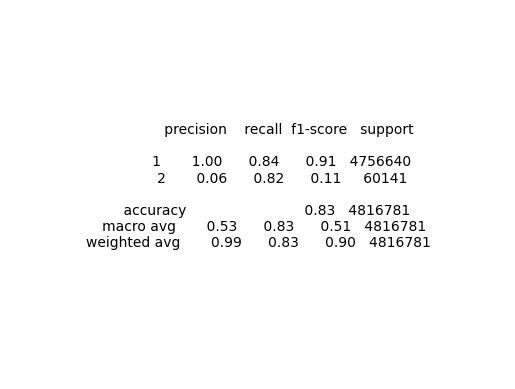

In [ ]:
## RUN

# setting seed for PyTorch
set_seed(SEED)
wandb.config.seed = SEED

# Hyperparameters
bert_model_name='bert-base-uncased'

data_set_type='all' # 'all' or 'medium'

loss_type='cross_entropy' # 'focal' or 'cross_entropy'

train_size=0.8
val_size=0.1
test_size=0.1

batch_size = 64
num_epochs=3

class_h_factor = 1
num_unfreeze_layers = 2

focal_alpha=[0,0.1,0.9,0]
focal_gamma=2.0

use_scheduler=False
learning_rate=0.001
eps_rate=1e-8

num_BILSTM_layers=2

# Log all important hyperparameters
wandb.config.update({
    'bert_model_name': bert_model_name,
    'loss_type': loss_type,
    'train_size': train_size,
    'val_size': val_size,
    'test_size': test_size,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'class_h_factor': class_h_factor,
    'num_unfreeze_layers': num_unfreeze_layers,
    'focal_alpha': focal_alpha,
    'focal_gamma': focal_gamma,
    'use_scheduler': use_scheduler,
    'learning_rate': learning_rate,
    'eps_rate': eps_rate,
    'data_set_type' : data_set_type,
    'num_BILSTM_layers' : num_BILSTM_layers
})

# Set-up data & data loaders
train_dataloader, val_dataloader, test_dataloader, y_train = setup_data(X, y, attention_masks, positions, train_size=train_size, val_size=val_size, test_size=test_size, batch_size=batch_size, random_state=SEED)

# Class weights calculation
class_weights, weights_dict = calculate_class_weights(y_train, device, class_h_factor)

model = setup_model(bert_model_name=bert_model_name, num_classes=4, num_unfreeze_layers=num_unfreeze_layers, num_BILSTM_layers=num_BILSTM_layers)

optimizer, loss_function, scheduler = set_up_loss_optimizer(
    model=model,
    train_dataloader=train_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    eps=eps_rate,
    loss_type=loss_type,
    use_scheduler=use_scheduler,
    class_weights=class_weights,
    alpha=focal_alpha,  # For Focal Loss
    gamma=focal_gamma    # For Focal Loss
)


# Train and validate the model for the specified number of epochs
for epoch in range(num_epochs):
    train_model(model, train_dataloader, optimizer, loss_function, epoch, scheduler)  # add epoch back in?

    validate_model(model, val_dataloader,loss_function, epoch)


# Test the model
test_model(model, test_dataloader, loss_function)



# setup tokenizer for inference
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

label_tokenizer = Tokenizer(filters='', lower=False)

# Explicitly set the word_index
label_tokenizer.word_index = {'normaltext': 1, 'highlight': 2}
# This assumes 'X' is used for subword tokens and 'PAD' is used for padding tokens
label_tokenizer.word_index['X'] = len(label_tokenizer.word_index) + 1
label_tokenizer.word_index['PAD'] = 0





# save the model
model_name = run_name + '.pt'
save_model_to_drive(model, model_name) # set-up


html_files = inference_testing('/content/drive/MyDrive/thesis_files/inference_docs_file.json', model, run_name)


# Upload each HTML file to Weights & Biases
for file in html_files:
    wandb.save(file)

wandb.finish()
